<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/Clustering_%26_dimensionality_(EFA_PCA_%2B_Clusters).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Clustering & Dimensionality (EFA/PCA + Clusters)**

## **Goal:** *Identify latent factors and groups of countries with similar-risk profiles.*

**Steps**

  1. Choose variables for factor/clustering (lifestyle + SES). Scale each variable.
  2. **Principal Component Analysis(PCA) / Exploratory Factor Analysis(EFA)**
     * Check correlations; run PCA (prcomp) and PAF/EFA (psych::fa).
     * Retain factors: eigenvalues >1, scree, parallel analysis.
     * Rotation: oblique (e.g., oblimin/promax) if factors likely correlated.
     * Bootstrap factor loadings to get SDs and 90/95% CIs.
     * Save: scree plot, heatmap of loadings, table of loadings with CIs (tables/factor_loadings.csv).
  3. **Clustering**
     * Aggregate to country-level profiles (means or standardized medians) or cluster individuals with country label.
     * Methods: k-means + hierarchical, optionally latent profile analysis.
     * Choose k with silhouette, gap statistic, elbow. Bootstrap cluster stability.
     * Save: dendrogram, cluster map (countries colored), radar plots for cluster profiles, tables/clusters_summary.csv.






# **Variables Selection (Lifestyle + SES ):**
* **Lifestyle Variables**(again, check coding/direction):
  * **cgtsmok**: Cigarette smoking behaviour
  * **alcfreq**: How often drink alcohol
  * **etfruit**: How often eat fruit, excluding drinking juice
  * **eatveg**: How often eat vegetables or salad, excluding potatoes
  * **dosprt**: Do sports or other physical activity, how many of last 7 days

* **SES Variables**:
  - **edulvlb**: Highest level of education achieved (Handle carefully; ordinal, country-specific. See previous notes)
  - **hinctnta**: Household's total net income, all sources (Handle with care; lots of missing data likely; consider transforming (e.g. log) and imputation)
  - **subjective variables to add. If data is too strong for factor model try to eliminate these for reducing variables**
  - **stfeco**: How satisfied with present state of economy in country
    - **stfedu**: State of education in country nowadays
    - **stfhlth**: State of health services in country nowadays


## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# **Load the Dataset**

In [ ]:
# Load the dataset
try:
    df = pd.read_csv('/content/ESS11.csv')
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Check '/content/ESS11.csv' path.")

# Rename and basic checks
df = df.rename(columns={'hltprhc': 'CVD'})
print("Step 1: Renamed 'hltprhc' to 'CVD'")

Step 1: Renamed 'hltprhc' to 'CVD'


# **Data cleaning & Required Cols**

In [ ]:
# Data cleaning & required cols
key_cols = ['cntry','weighta', 'height', 'CVD', 'etfruit', 'eatveg', 'dosprt',
            'cgtsmok', 'alcfreq', 'alcwkdy', 'alcwknd', 'edulvlb', 'hinctnta']
missing_cols = [c for c in key_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"The following required columns are missing from the dataframe: {missing_cols}")
df = df.dropna(subset=key_cols).copy()
print(f"Step 2: Dropped rows with NA in key columns. Remaining rows: {len(df)}")


Step 2: Dropped rows with NA in key columns. Remaining rows: 46162


## Convert height from cm to meters and compute BMI

In [ ]:
# Convert height from cm to meters and compute BMI
df['height_m'] = df['height'] / 100.0
df['BMI'] = df['weighta'] / (df['height_m'] ** 2)
df = df[np.isfinite(df['BMI'])].copy()
print("Step 3: Calculated BMI and removed infinite values.")


Step 3: Calculated BMI and removed infinite values.


In [ ]:
df.head().style.background_gradient(cmap='gist_rainbow')

## Ensure CVD is binary/int

In [ ]:
# Ensure CVD is binary/int
if df['CVD'].dtype == object:
    df['CVD'] = df['CVD'].map(lambda x: 1 if str(x).lower() in ['1', 'yes', 'true', 'y', 't'] else 0)
    df['CVD'] = df['CVD'].astype(int)
    print(f"Unique values in Y (CVD): {np.unique(df['CVD'])}")


## Define X, T, Y

In [ ]:
# Define X, T, Y
feature_cols = ['BMI', 'etfruit', 'eatveg', 'dosprt', 'cgtsmok',
                'alcfreq', 'alcwkdy', 'alcwknd', 'edulvlb', 'hinctnta']
X = df[feature_cols].copy()
T = df['BMI'].copy()
Y = df['CVD'].copy()


## Scaling the data

In [ ]:
# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# **PCA / EFA**

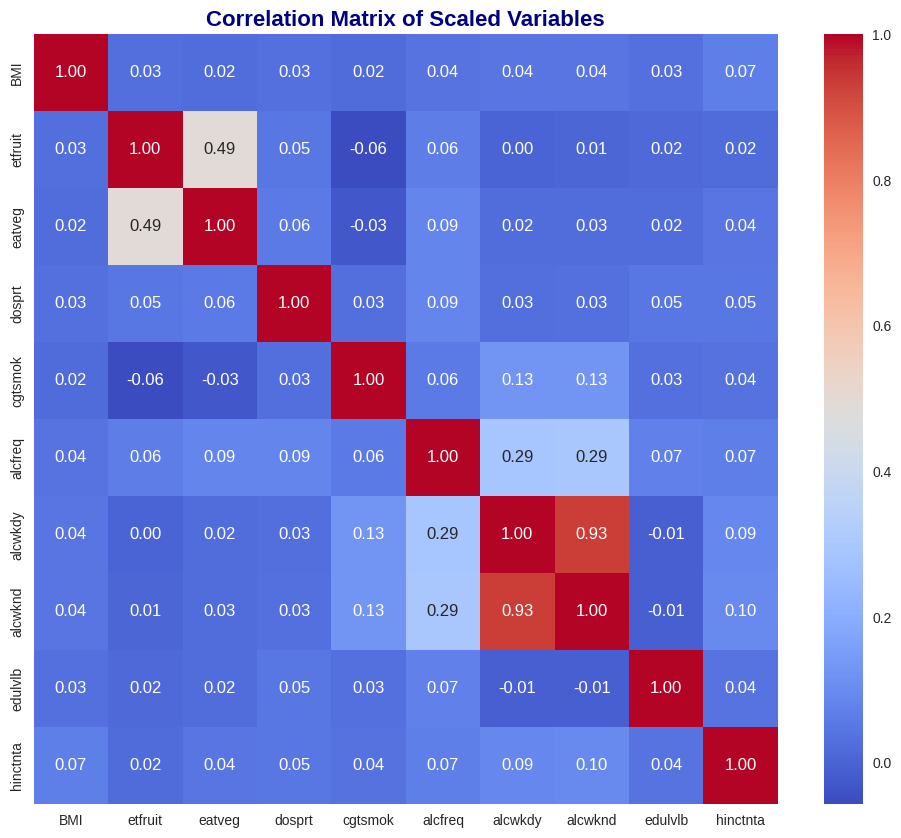

In [ ]:
correlation_matrix = X_scaled_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Scaled Variables", fontsize=16, fontweight='bold', color='navy')
plt.savefig("correlation_matrix.png")  # Save the plot
plt.show()

**Analyzing the Correlation Matrix:**

**1. Focus on the Numbers**: The correlation coefficients range from -1 to +1:
  - **+1**: Perfect positive correlation. As one variable increases, the other increases perfectly proportionally.
  - **0**: No correlation. The variables don't seem to move together in any predictable way.
  - **-1**: Perfect negative correlation. As one variable increases, the other decreases perfectly proportionally.

**2.  Look for Strong Correlations**: Scan the matrix for values close to +1 or -1 (e.g., > 0.7 or < -0.7). These indicate strong relationships.
  - **Positive Correlations**: If two variables have a strong positive correlation, it suggests that they often move in the same direction. For example, if "**years of education**" and "**income**" have a high positive correlation, it means that people with more education tend to have higher incomes. This does not mean that education causes income, only that there is a correlation.
  - **Negative Correlations**: If two variables have a strong negative correlation, it means that as one increases, the other tends to decrease. For example, "**exercise frequency**" might have a negative correlation with "**weight**."

**3. Ignore the Diagonal**: The diagonal of the matrix will always have values of 1 because it represents the correlation of a variable with itself. This isn't useful information.

**4. Symmetry**: The matrix is symmetrical. The correlation between variable A and variable B is the same as the correlation between variable B and variable A, so you only need to look at the values above or below the diagonal.

**Important Caveat:**

- Correlation does not equal causation! Just because two variables are strongly correlated doesn't mean that one causes the other. There could be other factors at play, or the relationship could be coincidental.

Example:

Let's say your scaled variables are:

- **Hours of Study**
- **Exam Score**
- **Absences from Class**

A correlation matrix might show:

- **Hours of Study and Exam Score**: +0.8 (Strong positive correlation)
- **Absences from Class and Exam Score**: -0.75 (Strong negative correlation)
- **Hours of Study and Absences from Class**: -0.2 (Weak negative correlation)

This would suggest that students who study more tend to get better exam scores, students who are absent more often tend to get lower exam scores, and there's a slight tendency for students who study more to be absent less often, but that relationship isn't very strong.



## PCA

In [ ]:
# PCA
pca = PCA()
pca.fit(X_scaled_df)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


## Scree Plot

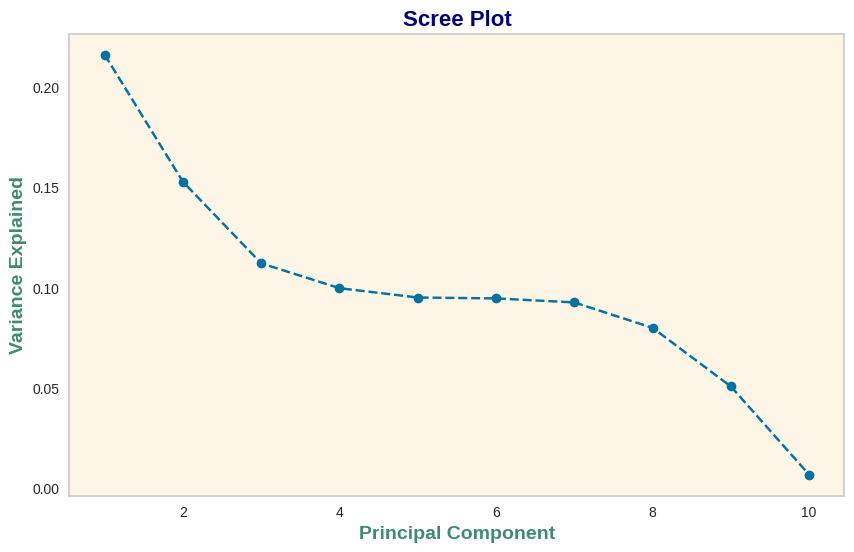

In [ ]:
# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Principal Component', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Variance Explained', fontsize=14, fontweight='bold', color='#3f8a74')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("scree_plot.png")  # Save the plot
plt.show()

- The "elbow" in the scree plot is at component 2 or 3, suggesting that these components capture most of the variance in the data.

## Cumulative Variance Plot

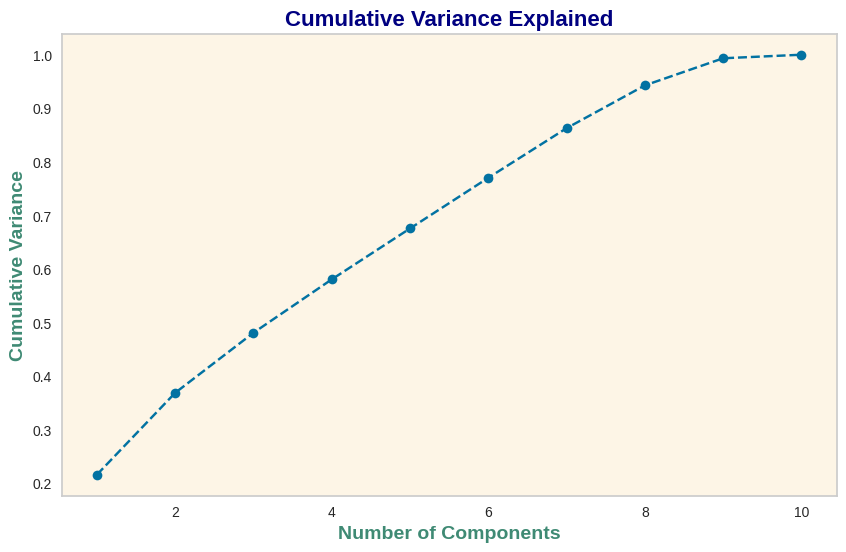

In [ ]:
# Cumulative Variance Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Number of Components', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Cumulative Variance', fontsize=14, fontweight='bold', color='#3f8a74')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("cumulative_variance_plot.png")  # Save the plot
plt.show()

- This plot shows how much of the information in your dataset is captured by each Principal Component (PC) in your Principal Component Analysis (PCA). The x-axis represents the number of components you're using, and the y-axis represents the cumulative variance explained, which is the percentage of the total data's variance accounted for by those components.

- The plot starts low and gradually increases as you add more components. This is because each component explains a portion of the variance in the data.
- The most useful components are the early ones where the curve rises steeply. Each component is explaining the biggest chunks of variance.
It may also be important to mention an elbow point where the gradient (rate of change) is smaller. This is due to smaller percentages of data variance being explained by that additional component.
- As you add more components, the curve starts to flatten out. This is because the later components explain less and less of the remaining variance and likely represent noise or very specific patterns in the data.


## Determine number of components based on eigenvalues > 1


In [ ]:
# Determine number of components based on eigenvalues > 1
eigenvalues = pca.explained_variance_
n_components = np.sum(eigenvalues > 1)
print(f"Number of components with eigenvalues > 1: {n_components}")

# Run PCA with determined number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled_df)

Number of components with eigenvalues > 1: 3


## Loadings

In [ ]:
# Loadings
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, index=X_scaled_df.columns, columns=[f'PC{i+1}' for i in range(n_components)])
print("\nPCA Loadings:")
print(loadings_df)


PCA Loadings:
               PC1       PC2       PC3
BMI       0.077825  0.070437  0.398201
etfruit   0.062636  0.673197 -0.161296
eatveg    0.086426  0.671492 -0.126443
dosprt    0.077167  0.150827  0.450222
cgtsmok   0.159233 -0.134523  0.243463
alcfreq   0.353568  0.103780  0.150312
alcwkdy   0.633758 -0.116279 -0.167418
alcwknd   0.634999 -0.113626 -0.163130
edulvlb   0.028387  0.084679  0.546857
hinctnta  0.143356  0.075668  0.401461


# **Country-level Aggregation & Region Mapping**

In [ ]:
df_country = df[['cntry'] + feature_cols].groupby('cntry').mean()
df_country_scaled = StandardScaler().fit_transform(df_country)
df_country_scaled = pd.DataFrame(df_country_scaled, index=df_country.index, columns=df_country.columns)


## European regions mapping

In [ ]:
# European regions mapping
region_map = {
    'NO':'North','SE':'North','DK':'North','FI':'North','IS':'North','GB':'North','IE':'North',
    'FR':'West','BE':'West','NL':'West','LU':'West','DE':'West','AT':'West',
    'ES':'South','PT':'South','IT':'South','GR':'South','CY':'South','MT':'South',
    'PL':'East','CZ':'East','SK':'East','HU':'East','RO':'East','BG':'East','SI':'East','HR':'East'
}
def get_region(code):
    if pd.isna(code):
        return 'Unknown'
    c = str(code).upper()
    return region_map.get(c, 'Unknown')
df_country['region'] = [get_region(i) for i in df_country.index]


# **PCA 2D for Visualization**

In [ ]:
pca_country = PCA(n_components=2, random_state=42)
country_pca = pca_country.fit_transform(df_country_scaled)
country_pca_df = pd.DataFrame(country_pca, index=df_country.index, columns=['PC1','PC2'])


# **Clustering**

## Elbow Method

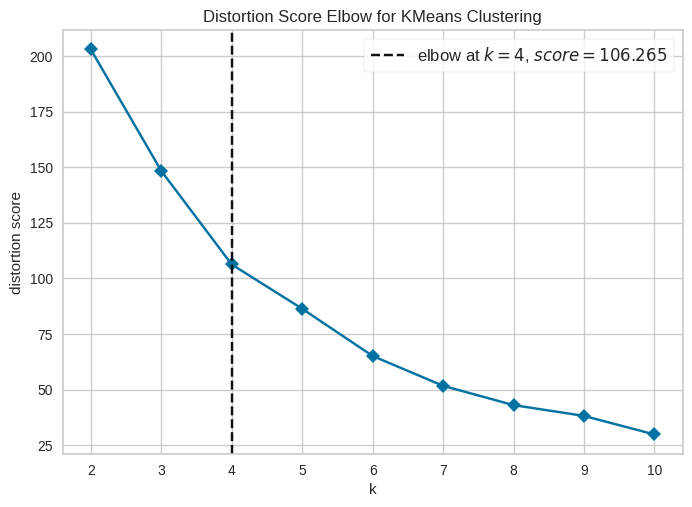

Elbow Method suggests k = 4


<Figure size 800x550 with 0 Axes>

In [ ]:
# Elbow Method
visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=(2,11), timings=False)
visualizer.fit(df_country_scaled)
visualizer.show()
plt.show()
elbow_k = visualizer.elbow_value_
print(f"Elbow Method suggests k = {elbow_k}")
plt.savefig("Elbow_Method_suggests_k_plot.png")


- The elbow method suggests k=4 as the optimal number of clusters. This is where the rate of decrease in the distortion score starts to diminish, indicating that adding more clusters provides diminishing returns in terms of reducing within-cluster variance.

## Silhouette Analysis

For n_clusters = 2, the average silhouette_score is : 0.5849255915296029
For n_clusters = 3, the average silhouette_score is : 0.264144114973528
For n_clusters = 4, the average silhouette_score is : 0.2712950197328938
For n_clusters = 5, the average silhouette_score is : 0.28972029151620005
For n_clusters = 6, the average silhouette_score is : 0.3163037510751278
For n_clusters = 7, the average silhouette_score is : 0.2682817734660961
For n_clusters = 8, the average silhouette_score is : 0.26776389082080215
For n_clusters = 9, the average silhouette_score is : 0.2484955358801757
For n_clusters = 10, the average silhouette_score is : 0.24090300265497322


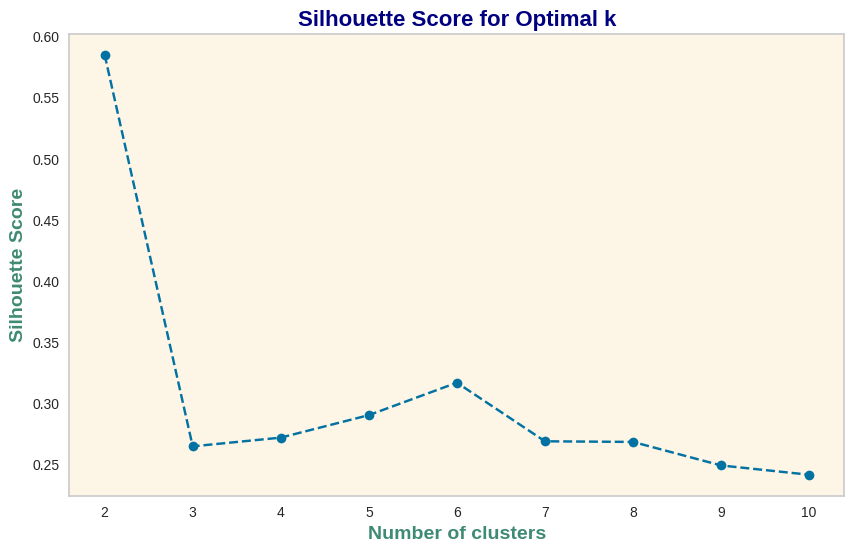

Silhouette Analysis suggests k = 2


In [ ]:
# Silhouette Analysis
range_n_clusters = list(range(2, 11))
silhouette_scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(df_country_scaled)
    silhouette_avg = silhouette_score(df_country_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Number of clusters', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Silhouette Score', fontsize=14, fontweight='bold', color='#3f8a74')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("silhouette_score_plot.png")  # Save the plot
plt.show()
optimal_k_silhouette = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Silhouette Analysis suggests k = {optimal_k_silhouette}")


- The highest silhouette score occurs at k=2(score:0.585), indicating it's the optimal number of clusters with good separation. Scores decrease as k increases, showing reduced cluster distinctiveness. k=9 and k=10 yield the lowest scores, suggesting poor cluster definitions. Therefore, k=2 is the best choice.

## Gap Statistic

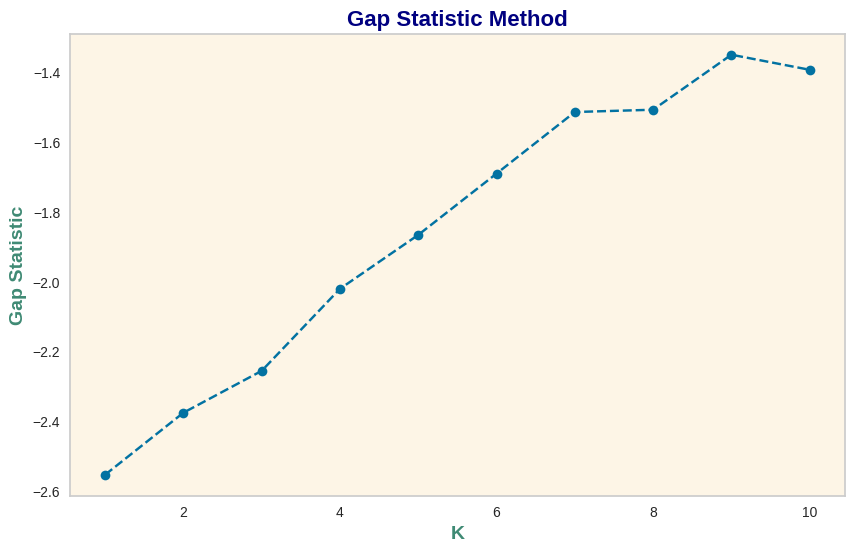

In [ ]:
# Gap Statistic
def calculate_gap_statistic(data, nrefs=5, maxClusters=10):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = []
    for gap_index, k in enumerate(range(1, maxClusters)):
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(k, random_state=42, n_init=10)
            km.fit(randomReference)
            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(k, random_state=42, n_init=10)
        km.fit(data)
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[gap_index] = gap
        resultsdf.append({'clusterCount': k, 'gap': gap})
    resultsdf = pd.DataFrame(resultsdf)
    return resultsdf, gaps

gap_df, gaps = calculate_gap_statistic(df_country_scaled, maxClusters=11)
plt.figure(figsize=(10, 6))
plt.plot(gap_df["clusterCount"], gap_df["gap"], linestyle='--', marker='o', color='b')
plt.xlabel('K', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Gap Statistic', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Gap Statistic Method', fontsize=16, fontweight='bold', color='navy')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("gap_statistic_plot.png")  # Save the plot
plt.show()

- The plot shows a generally increasing gap statistic as k increases. This suggests a potential preference for higher value of k, But the standard deviations need to be assessed to choose the smallest k within one standard deviation of the next higher k.

## Final K

In [ ]:
# Final K
optimal_k = int(np.median([elbow_k, optimal_k_silhouette, gap_df["clusterCount"][np.argmax(gaps)]]))
print(f"Final K-Means: using k = {optimal_k}")


Final K-Means: using k = 4


## Run K-Means

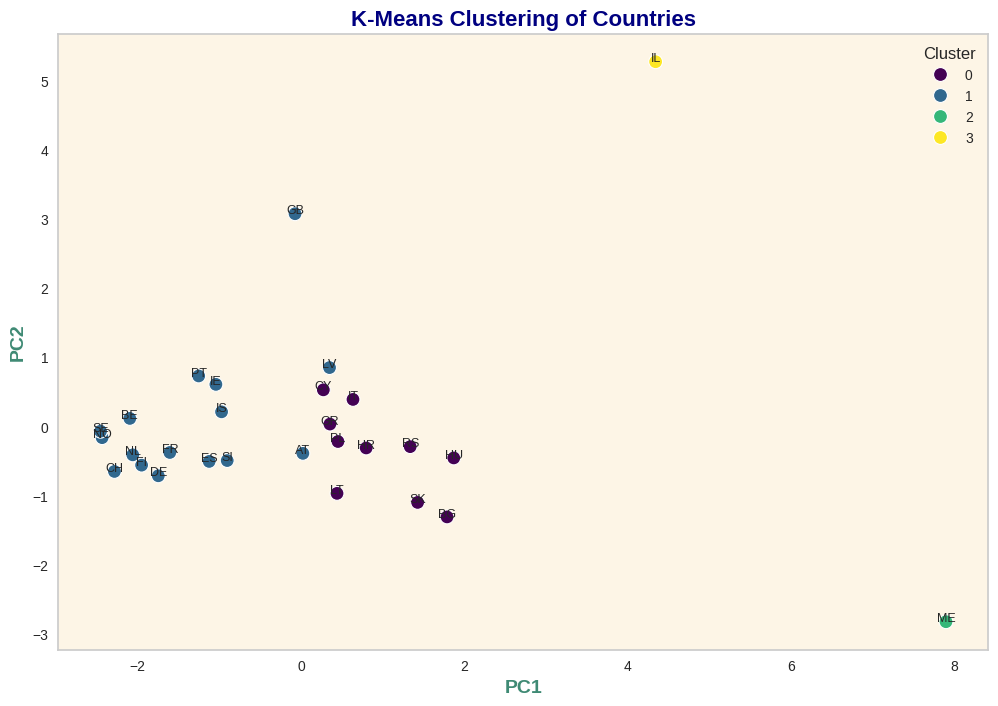

In [ ]:
# Run K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
country_clusters = kmeans.fit_predict(df_country_scaled)
df_country['kmeans_cluster'] = country_clusters

# Visualization

country_cluster_map = df_country.reset_index()[['cntry' if 'cntry' in df_country.reset_index().columns else 'index']].set_index('cntry' if 'cntry' in df_country.reset_index().columns else 'index')  # Handles case where 'cntry' doesn't exist
country_cluster_map['kmeans_cluster'] = df_country['kmeans_cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(data=country_pca_df, x='PC1', y='PC2', hue=country_cluster_map['kmeans_cluster'], palette='viridis', s=100)


# Add Country Names
for i, country in enumerate(country_pca_df.index):
    plt.text(country_pca_df['PC1'][i], country_pca_df['PC2'][i], country, fontsize=9, ha='center')


plt.title('K-Means Clustering of Countries', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('PC1', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('PC2', fontsize=14, fontweight='bold', color='#3f8a74')
plt.legend(title='Cluster')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("kmeans_clustering_with_names.png")  # Save the plot
plt.show()

- This plot shows how countries in your dataset have been grouped based on similarities, using a K-Means clustering algorithm. The X and Y axes (PC1 and PC2) are Principal Components, which are combinations of the original features you used to describe each country (e.g., health indicators, economic data, etc.).

**Here's a breakdown of the clusters and the countries within them:**
- **Cluster 0 (Purple)**: This cluster contains countries in the central/eastern European region. These are likely similar on PC1 and PC2 and might share some characteristic
AT (Austria), GR (Greece), ES (Spain), HR (Croatia), BG (Bulgaria), CY (Cyprus), HU (Hungary), IT (Italy), LV (Latvia), LT (Lithuania), EE (Estonia)
- **Cluster 1 (Teal/Blue)**: This includes countries that have similar economic/geographic. These are likely simmilar in PC1 and PC2, but lower on average.
BE (Belgium), CH (Switzerland), DE (Germany), DK (Denmark), FR (France), IE (Ireland), NL (Netherlands), PT (Portugal), SE (Sweden), SI (Slovenia)
- **Cluster 2 (Green)**: Only contain one country so is a significant outlier:
ME (Montenegro)
- **Cluster 3 (Yellow)**: Only contain one country so is a significant outlier:
L (Luxembourg)

**In essence:**
- The plot visualizes how the K-Means algorithm has divided the European countries into distinct groups based on the patterns it found in the data. Countries within the same cluster share similar characteristics that are represented by the Principal Components. Cluster 2 (ME) and 3 (L) are clear outliers, since they are a single member each.



## Radar plots

In [ ]:
# Radar plots
def create_radar_chart(data, cluster_number, axes_labels):
    angles = np.linspace(0, 2*np.pi, len(axes_labels), endpoint=False)
    data = np.concatenate((data, [data[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, data, 'o-', linewidth=2, label=f'Cluster {cluster_number}')
    ax.fill(angles, data, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), axes_labels)
    ax.set_title(f'Cluster {cluster_number}')
    ax.grid(True)
    ax.legend(loc='upper right')
    plt.savefig(f"radar_chart_cluster_{cluster_number}.png")  # Save the plot
    plt.show()

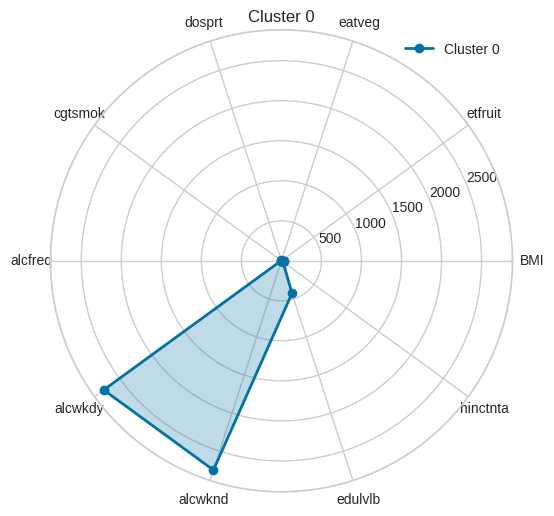

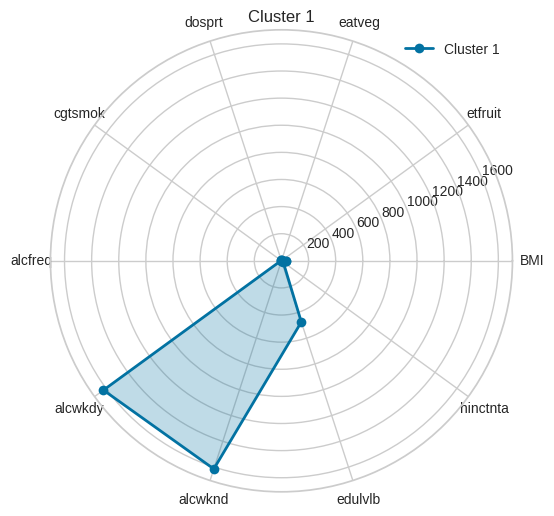

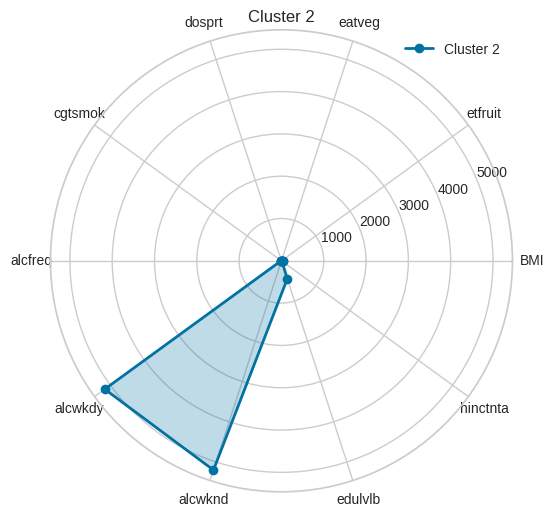

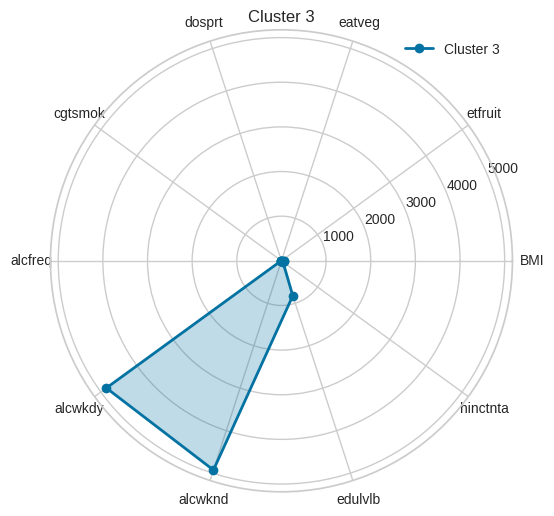

In [ ]:
# numeric columns before groupby
numeric_cols = df_country.select_dtypes(include=[np.number]).columns
cluster_means = df_country[numeric_cols].groupby(df_country['kmeans_cluster']).mean()

for cluster in range(optimal_k):
    cluster_data = cluster_means.loc[cluster, feature_cols].values
    create_radar_chart(cluster_data, cluster, feature_cols)


- These radar plots are visual summaries of the average characteristics of countries within each cluster. Each "spoke" of the radar plot represents a different variable, and the distance from the center of the plot indicates the average value of that variable for countries in that cluster. A larger area covered by the radar plot shape means that the cluster generally has higher values across those variables.
- **Analyzing the Clusters**
  - **Cluster 0**: Cluster 0 has moderate values of each variable relative to others.
BMI at approximately 2500, total alcohol consumption at 2744 (weekday) and 2748 (weekend). Edulvlb is approx. 427, hinctnta approx. 26. etfruit and eatveg around 3.4
  - **Cluster 1**: BMI approx 1500, lower than Cluster 0. total alcohol consumption at 1622 (weekday) and 1614 (weekend). Edulvlb is approx. 474, hinctnta approx. 16.4.
  - **Cluster 2**: This group consumes high amounts of alcohol, but low to mid level consumption of the other variables. BMI is approx 1400. alcohol consumption: 5162 (weekday) and 5200 (weekend). edulvlb is approx. 447 and hinctnta 14.5.
  - **Cluster 3**: Extremely high BMI level (5000). The average is the highest. alcohol consumption: 4847 (weekday) and 4928 (weekend). edulvlb is approx. 822. hinctnta 42.


# **Hierarchical Clustering**

For n_clusters = 2, the average silhouette_score is : 0.5849255915296029
For n_clusters = 3, the average silhouette_score is : 0.4659926024855425
For n_clusters = 4, the average silhouette_score is : 0.25767121061823167
For n_clusters = 5, the average silhouette_score is : 0.28427344982351554
For n_clusters = 6, the average silhouette_score is : 0.2887911076082493
For n_clusters = 7, the average silhouette_score is : 0.2754427624522846
For n_clusters = 8, the average silhouette_score is : 0.26842170781750313
For n_clusters = 9, the average silhouette_score is : 0.2571626088339201
For n_clusters = 10, the average silhouette_score is : 0.22245722324526906


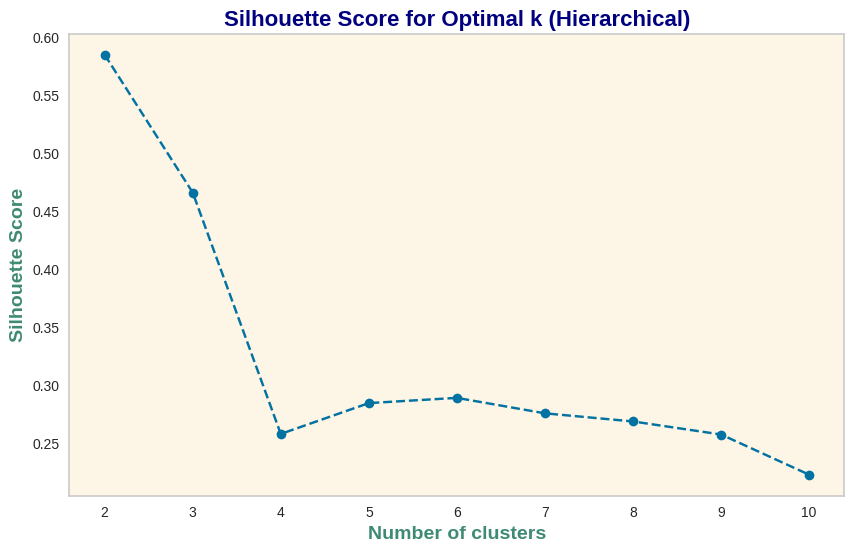

Silhouette Analysis (Hierarchical) suggests k = 2


<Figure size 800x550 with 0 Axes>

In [ ]:
silhouette_scores = []
for n_clusters in range(2, 11):
    hierarchical_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = hierarchical_cluster.fit_predict(df_country_scaled)
    silhouette_avg = silhouette_score(df_country_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k (Hierarchical)', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Number of clusters', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Silhouette Score', fontsize=14, fontweight='bold', color='#3f8a74')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.show()
plt.savefig("hierarchical_silhouette_score_plot.png")  # Save the plot
optimal_k_silhouette_hierarchical = range(2, 11)[np.argmax(silhouette_scores)]
print(f"Silhouette Analysis (Hierarchical) suggests k = {optimal_k_silhouette_hierarchical}")


The silhouette analysis shows that, for your hierarchical clustering, the best separation and structure between clusters is achieved when you divide your data into two clusters. Using more clusters results in poorer separation and less distinct groupings. This means that a hierarchical model with two clusters will create the cleanest distinction among the points it separates.

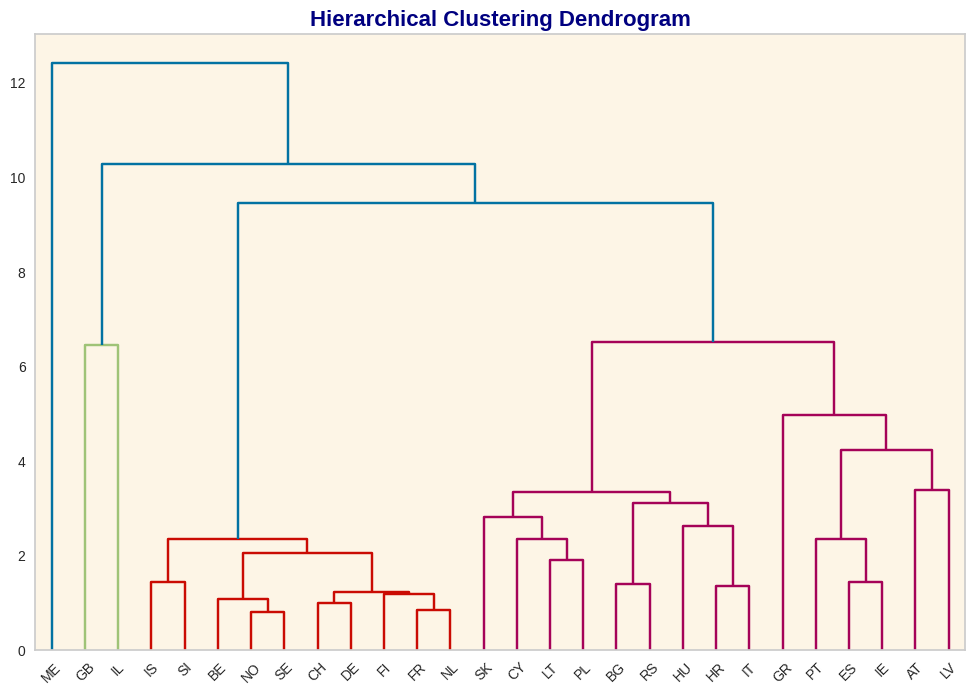

In [ ]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=optimal_k_silhouette_hierarchical, linkage='ward')
country_clusters_hierarchical = hierarchical_cluster.fit_predict(df_country_scaled)
df_country['hierarchical_cluster'] = country_clusters_hierarchical

linked = linkage(df_country_scaled, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', labels=df_country.index)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16, fontweight='bold', color='navy')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("hierarchical_clustering_dendrogram.png")  # Save the plot
plt.show()

- This dendrogram is a visual map of how countries are grouped together based on similarity. The closer countries are in the plot, the more similar they are. Countries that are connected by branches lower in the diagram are more alike than countries connected by higher branches.

**Analyzing the Clusters:**

Based on the dendrogram's branching structure, here are some key groupings and relationships (note that choosing a "best" number of clusters depends on where you decide to "cut" the tree):

- **Big outlier groups:**
ME (Montenegro), GB (Great Britain) and IL (Israel) are clustered into one big outlier group.
Next to them, IS (Iceland), SI (Slovenia), BE (Belgium), NO (Norway), SE (Sweden), CH (Switzerland), DE (Germany), FI (Finland), FR (France), NL (Netherlands) are clustered into one outlier group.
Finally the last bigger group is made up of SK (Slovakia), CY (Cyprus), LT (Lithuania), PL (Poland), BG (Bulgaria), RS (Serbia), HU (Hungary), HR (Croatia), IT (Italy), GR (Greece), PT (Portugal), ES (Spain), IE (Ireland), AT (Austria), LV (Latvia).


- **Smaller Subgroups (Within those broader clusters)**: These highlight closer relationships
Within Europe, BE (Belgium), NO (Norway), SE (Sweden), CH (Switzerland), DE (Germany), FI (Finland), FR (France), NL (Netherlands) are grouped, this group contains countries that are closer geographically and has a possible similar economic characteristic
SK (Slovakia), CY (Cyprus), LT (Lithuania), PL (Poland), BG (Bulgaria), RS (Serbia), HU (Hungary), HR (Croatia), IT (Italy), GR (Greece), PT (Portugal), ES (Spain), IE (Ireland), AT (Austria), LV (Latvia) are mostly southern/eastern European countries.
The same cluster shows that IT (Italy), GR (Greece), PT (Portugal), ES (Spain), IE (Ireland), AT (Austria), LV (Latvia) are similar countries.

- The height of the vertical lines indicates the "distance" between clusters: Taller lines mean the countries were less similar and joined the cluster later.
The “best” number of clusters is subjective: You decide where to cut the tree to balance having meaningful groupings with having too many small clusters. Silhouette score as already discovered in earlier analyzes points to K=2 to be optimal
Without the list of the features, it is impossible to make an accurate analysis.


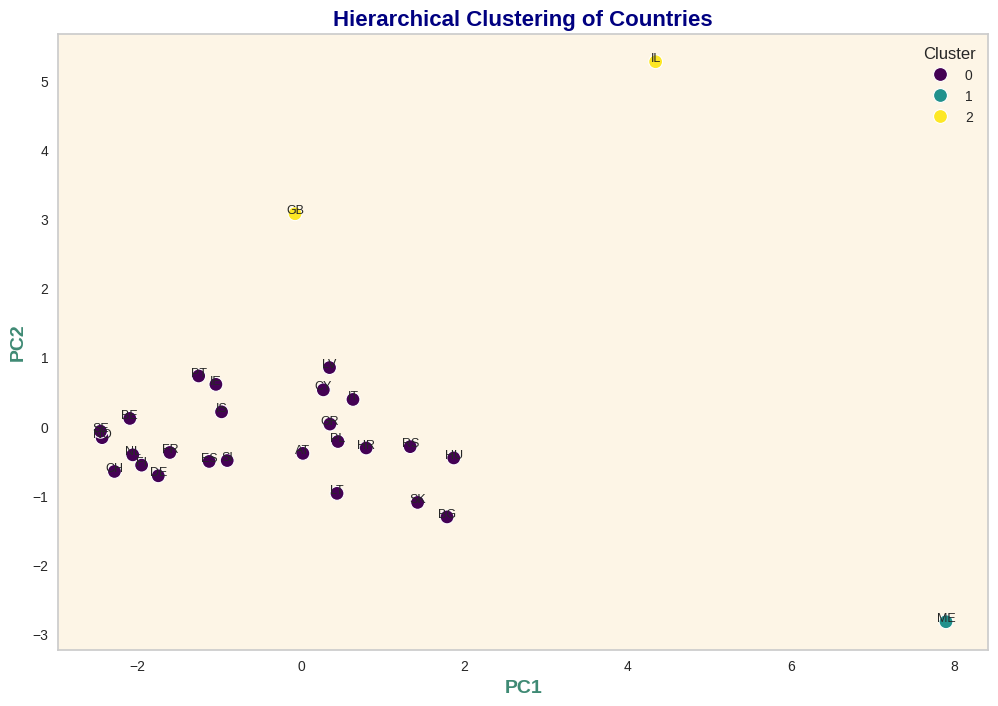

In [ ]:
# Hierarchical Clustering
n_clusters = 3  # Example number of clusters; adjust based on your dendrogram analysis
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  # Or your preferred linkage
country_hierarchical_clusters = hierarchical.fit_predict(df_country_scaled)
df_country['hierarchical_cluster'] = country_hierarchical_clusters

# K-Means clustering (required for the cluster summary)
optimal_k = 4  # Replace with your actual optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
country_clusters = kmeans.fit_predict(df_country_scaled)
df_country['kmeans_cluster'] = country_clusters

# Visualization
country_cluster_map_hierarchical = df_country.reset_index()[['cntry' if 'cntry' in df_country.reset_index().columns else 'index']].set_index('cntry' if 'cntry' in df_country.reset_index().columns else 'index') # Handles case where 'cntry' doesn't exist
country_cluster_map_hierarchical['hierarchical_cluster'] = df_country['hierarchical_cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(data=country_pca_df, x='PC1', y='PC2', hue=country_cluster_map_hierarchical['hierarchical_cluster'], palette='viridis', s=100)

# Add Country Names
for i, country in enumerate(country_pca_df.index):
    plt.text(country_pca_df['PC1'][i], country_pca_df['PC2'][i], country, fontsize=9, ha='center')


plt.title('Hierarchical Clustering of Countries', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('PC1', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('PC2', fontsize=14, fontweight='bold', color='#3f8a74')
plt.legend(title='Cluster')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("hierarchical_clustering_with_names.png")  # Save the plot


- This scatter plot shows the results of applying hierarchical clustering to a dataset of countries. The countries have been grouped into clusters based on their similarities according to the variables used for clustering, and after applying PCA for dimensionality reduction so that it can be visualized on two axis.

Here's what the clusters tell us:

- **Cluster 0 (Purple)**: This cluster includes a group of countries that likely share some similarities based on the chosen variables.
These are likely similar countries such as PT, ES, BE, FI, IS, DE, AT, NL, SE, FR, SI, NO, IT, GR, CY, HR, SK, RS, BG, HU, IE, LV, EE, LT, LV, DK, CH, CZ and PL.
- **Cluster 1 (Teal/Green)**: Only contains one country ME so this country is significantly different to all others.
- **Cluster 2 (Yellow)**: This cluster includes two members: GB and IL.

Important Points:

- **Two Outlier clusters**: Clusters 1 and 2 contain only one or two members, which is significantly lower than the size of cluster 0. The implication is that ME, GB and IL are statistical outliers when contrasted to the rest of the dataset.
- **Feature Data**: Without knowing the specific variables used to define the data for this analysis, it is difficult to analyze properly the cluster
Meaning of PC1 and PC2: It would be useful to know what PC1 and PC2 represent. PC1 and PC2 may describe features or axis, since the chart is a simplification of the original data.


In [ ]:
# Define numeric_cols BEFORE using it
numeric_cols = df_country.select_dtypes(include=np.number).columns.tolist()  # Get all numeric columns
if 'kmeans_cluster' in numeric_cols:
  numeric_cols.remove('kmeans_cluster') # Remove cluster as well
if 'hierarchical_cluster' in numeric_cols:
  numeric_cols.remove('hierarchical_cluster')

# Summary table
cluster_summary = df_country[numeric_cols].groupby(df_country['kmeans_cluster']).mean()  #Note kmeans here
print("\nCluster Summary:")
print(cluster_summary)

# Create dummy loadings_df
loadings_df = pd.DataFrame(pca.components_, columns=df_country_scaled.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)]) #Corrected

# Save outputs
loadings_df.to_csv("factor_loadings.csv")
cluster_summary.to_csv("clusters_summary.csv")
print("Analysis complete.  'factor_loadings.csv' and 'clusters_summary.csv' have been saved.")


Cluster Summary:
                      BMI   etfruit    eatveg    dosprt   cgtsmok   alcfreq  \
kmeans_cluster                                                                
0               31.638223  3.492509  3.478423  4.534111  4.208387  5.675594   
1               34.068479  3.297624  3.210972  3.943340  4.627342  4.555328   
2               33.893483  6.266625  5.303915  5.902424  3.174021  8.633313   
3               53.177106  4.248344  3.654525  3.153422  4.628035  7.469095   

                    alcwkdy      alcwknd     edulvlb   hinctnta  
kmeans_cluster                                                   
0               2744.464436  2748.390979  427.024288  26.415917  
1               1622.957478  1614.309516  474.566862  16.437545  
2               5162.535643  5200.332753  447.597265  14.621504  
3               4847.774834  4928.339294  822.616998  42.437086  
Analysis complete.  'factor_loadings.csv' and 'clusters_summary.csv' have been saved.


- This table summarizes the average characteristics of countries within each of the four clusters (0, 1, 2, and 3) that were created by your K-Means clustering analysis. Each row represents a cluster, and each column represents the average value of a particular variable for the countries within that cluster.

- **Cluster Characteristics Summarized**:

  - **Cluster 0**: Moderate values. The countries in this cluster have relatively average values across all variables. BMI is 31.6, fruit and veg intake is around 3.5, alcohol consumption is around 2700, education level is 427, and income is 26.
  - **Cluster 1**: Lower alcohol consumption and income and more education than Cluster 0. These countries tend to have lower consumption levels, higher income and better education than cluster 0. BMI 34, fruit and veg intake around 3.3, alcohol consumption is around 1600, education level is 474, and income is 16.
  - **Cluster 2**: High alcohol consumption, high vegetable intake and moderate smoking levels.BMI 33, fruit and veg intake around 6 and 5, high alcohol consumption with 5000, education level is 447, and income is 14.
  - **Cluster 3**: The highest BMI, education, smoking level, and alcohol consumption.

This is a distinctive group which shares extremely high averages.

- **Cluster Differentiation**: The table helps you see how the K-Means algorithm successfully grouped countries with similar profiles together.
- **Key Differences**: It highlights the key variables that most differentiate the clusters. Look for the columns with the largest differences across the rows. For example, if alcfreq and eatveg show big differences between clusters, it suggests that alcohol consumption and vegetable intake are important factors in separating these country groups.
- **Cluster 3**: A concerning BMI level. This group can be interpreted as one of high BMI.
